## Example using Histone modification data downloaded from Encode

In [3]:
import pandas as pd
import numpy as np
from scivae import VAE

# Set the location of the mnist data
data_dir ='../tests/data/'
df = pd.read_csv(f'{data_dir}mouse_HM_var500_data.csv')
df 

,entrezgene_id,external_gene_name,ensembl_gene_id,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_width,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF053GHW_width,...,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_width,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_signal,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_width,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_signal,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_width,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_signal,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_width,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_signal
0,497097,Xkr4,ENSMUSG00000051951,838.0,4.64805,2236.0,4.70623,NaN,NaN,841.0,...,459.0,4.17547,2522.0,32.56543,2456.0,37.44113,1852.0,6.81303,NaN,NaN
1,384198,Fam47e,ENSMUSG00000057068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12492,Scarb2,ENSMUSG00000029426,2053.0,16.06083,NaN,NaN,4699.0,4.03960,787.0,...,797.0,4.94311,862.0,20.08811,3071.0,61.25575,2503.0,24.87381,NaN,NaN
3,269113,Nup54,ENSMUSG00000034826,1546.0,23.33510,NaN,NaN,8433.0,4.30511,462.0,...,215.0,2.45555,1376.0,35.42474,2128.0,66.67310,1165.0,28.39603,425.0,3.4231
4,15945,Cxcl10,ENSMUSG00000034855,NaN,NaN,984.0,4.95978,NaN,NaN,1086.0,...,641.0,3.41532,794.0,13.95355,661.0,8.53067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,21762,Psmd2,ENSMUSG00000006998,1431.0,10.42818,NaN,NaN,4157.0,3.39655,1512.0,...,NaN,NaN,1407.0,13.44737,1765.0,61.31395,1525.0,20.17010,NaN,NaN
20396,73047,Camk2n2,ENSMUSG00000051146,2117.0,10.87675,3875.0,5.10808,734.0,3.56510,3664.0,...,656.0,4.96696,3348.0,26.86646,3417.0,25.29333,1863.0,7.71053,NaN,NaN
20397,107522,Ece2,ENSMUSG00000022842,1041.0,7.72166,3514.0,5.33374,NaN,NaN,1335.0,...,301.0,2.85033,1312.0,30.50417,1046.0,31.87724,926.0,10.12819,NaN,NaN
20398,208624,Alg3,ENSMUSG00000033809,2342.0,17.18692,NaN,NaN,754.0,5.22586,1288.0,...,NaN,NaN,3259.0,44.11346,2597.0,66.85134,834.0,9.84724,NaN,NaN


## Normalise the data

Before running the VAE we might only want to do it on a subset, here I'm interested in marks at day E10.5 
only in the brain.

In [4]:
df = df.fillna(0)
# Get out columns with HM values
cols = [c for c in df.columns if '10' in c and 'brain' in c and 'signal' in c]  # i.e. only do brain at E10 samples
# Make sure we log2 the values since they're too diffuse
vae_df = pd.DataFrame()
vae_df['external_gene_name'] = df['external_gene_name'].values
new_cols = []
for c in cols:
    new_name = ' '.join(c.split('_')[:-3]).replace('embryonic', '')
    new_cols.append(new_name)
    vae_df[new_name] = np.log2(df[c] + 1)

dataset = vae_df[new_cols].values
# Create and train VAE

In [8]:
! pip install numpy==1.19.5

  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
anceled
ERROR: Operation cancelled by user


## Train the VAE

We run the training of the VAE 

In [6]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

config = {"loss":
  {"loss_type": "mse",
    "distance_metric": "mmd",
    "mmd_weight": 1.0
  },
  "encoding": {
    "layers": [
      {"num_nodes": 64, "activation_fn": "relu"},
                {"num_nodes": 32, "activation_fn": "selu"}
        ]
  },
  "decoding": {
    "layers": [
                {"num_nodes": 32, "activation_fn": "selu"},
                {"num_nodes": 64, "activation_fn": "relu"}
        ]
  },
  "latent": {
    "num_nodes": 3 # Number of nodes in the centre
  },
  "optimiser": {
    "params": {"learning_rate": 0.001, "beta_1": 0.8, "beta_2": 0.97}, # You can set the params of these
    "name": "adamax"
  },
  "batch_norm": True
}

vae = VAE(dataset, dataset, ["None"] * len(dataset), config, f'vae_rcm')
vae.encode('default', epochs=10, batch_size=50)

None
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ default_input       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      1,472 │ default_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         99 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_sigma (Dense) │ (None, 3)         │         99 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_sigma[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,134 (16.15 KB)

 Trainable params: 3,942 (15.40 KB)

 Non-trainable params: 192 (768.00 B)

None
--------------------------------------------------------------------------------
                               Decoder summary:	                                
--------------------------------------------------------------------------------


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 22)             │         1,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 22)             │            88 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,142 (16.18 KB)

 Trainable params: 3,906 (15.26 KB)

 Non-trainable params: 236 (944.00 B)

None


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Quality control!

Check that the nodes follow **approximately** a normal distribution.

638/638 [==============================] - 1s 937us/step


/Users/ariane/opt/miniconda3/envs/test_scivae_2022/lib/python3.10/site-packages/sciviso/histogram.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(values, fit=norm, kde=self.plot_kde, rug=self.plot_rug, hist=self.plot_hist,


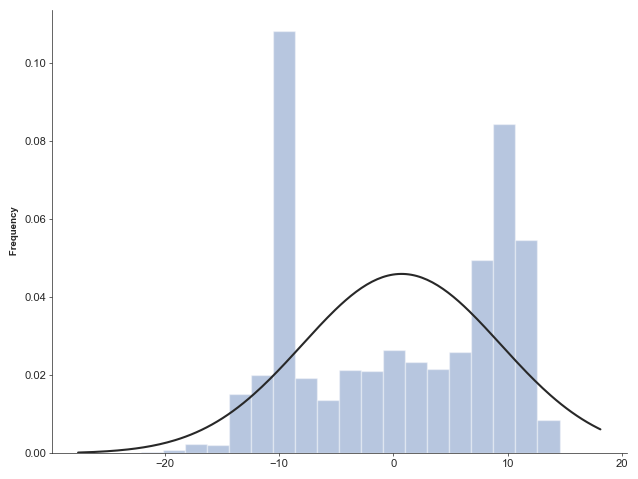

/Users/ariane/opt/miniconda3/envs/test_scivae_2022/lib/python3.10/site-packages/sciviso/histogram.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(values, fit=norm, kde=self.plot_kde, rug=self.plot_rug, hist=self.plot_hist,


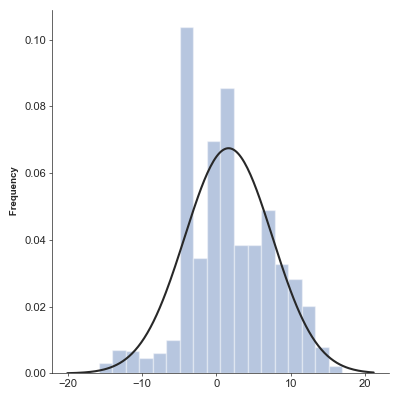

/Users/ariane/opt/miniconda3/envs/test_scivae_2022/lib/python3.10/site-packages/sciviso/histogram.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(values, fit=norm, kde=self.plot_kde, rug=self.plot_rug, hist=self.plot_hist,


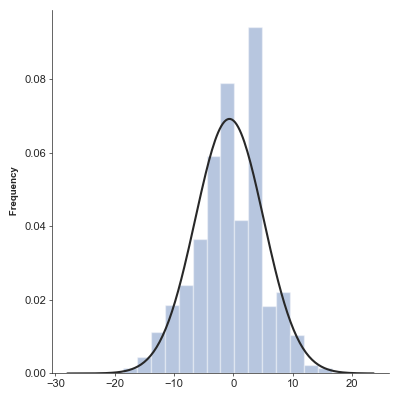

<Figure size 400x400 with 0 Axes>

In [4]:
from scivae import Vis

vis = Vis(vae, vae.u, None)
vis.plot_node_hists(show_plt=True, save_fig=False)

## Quality control 2: Visualise the correlation between features.

Since the VAE isn't magic, just good at learning correlations/patterns between input features, it's sensible 
to check that the correlations between features and nodes exists.

638/638 [==============================] - 1s 960us/step
1 forebrain 10.5-days  H3K27ac 0.8708057735286855 0.0
1 forebrain 10.5-days  H3K27me3 -0.09447534731531082 1.1409235745313082e-41
1 forebrain 10.5-days  H3K36me3 0.8069536534236774 0.0
1 forebrain 10.5-days  H3K4me1 0.5319978238992173 0.0
1 forebrain 10.5-days  H3K4me3 0.8352067747497098 0.0
1 forebrain 10.5-days  H3K9me3 -0.04067937738256932 6.164719552135299e-09
1 forebrain 13.5-days  H3K36me3 0.7917845128303242 0.0
1 forebrain 16.5-days  H3K9ac 0.834576023626034 0.0
1 hindbrain 10.5-days  H3K27ac 0.8688065530676085 0.0
1 hindbrain 10.5-days  H3K27me3 -0.1153008587030544 2.532249090467319e-61
1 hindbrain 10.5-days  H3K36me3 0.8084497176524241 0.0
1 hindbrain 10.5-days  H3K4me1 0.5214685530752681 0.0
1 hindbrain 10.5-days  H3K4me3 0.8612906972819069 0.0
1 hindbrain 10.5-days  H3K9me3 -0.04351132494438404 5.060279418312933e-10
1 hindbrain 16.5-days  H3K36me3 0.718663556836911 0.0
1 midbrain 10.5-days  H3K27ac 0.8729446663276165 0

<Figure size 400x400 with 0 Axes>

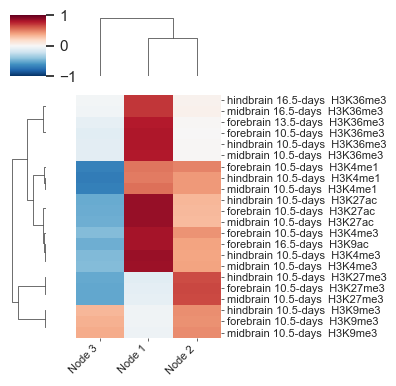

,Node 1,Node 1 padj,Node 2,Node 2 padj,Node 3,Node 3 padj,labels
0,0.870806,0.0,0.320996,0.000,-0.493981,0.0,forebrain 10.5-days H3K27ac
1,-0.094475,0.0,0.671069,0.000,-0.517568,0.0,forebrain 10.5-days H3K27me3
2,0.806954,0.0,0.007248,0.301,-0.115451,0.0,forebrain 10.5-days H3K36me3
3,0.531998,0.0,0.493358,0.000,-0.675782,0.0,forebrain 10.5-days H3K4me1
4,0.835207,0.0,0.452346,0.000,-0.433335,0.0,forebrain 10.5-days H3K4me3
5,-0.040679,0.0,0.456927,0.000,0.359135,0.0,forebrain 10.5-days H3K9me3
6,0.791785,0.0,0.014106,0.051,-0.091975,0.0,forebrain 13.5-days H3K36me3
7,0.834576,0.0,0.402698,0.000,-0.487686,0.0,forebrain 16.5-days H3K9ac
8,0.868807,0.0,0.332717,0.000,-0.501295,0.0,hindbrain 10.5-days H3K27ac
9,-0.115301,0.0,0.651930,0.000,-0.507855,0.0,hindbrain 10.5-days H3K27me3


In [5]:
vis.plot_node_feature_correlation(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, save_fig=False)

## Plot specific genes

Since we love certain genes, lets have a look at where they are on the latent space

638/638 [==============================] - 1s 1ms/step


<Figure size 400x400 with 0 Axes>

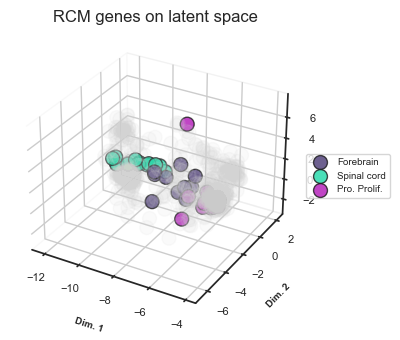

<Axes3DSubplot: title={'center': 'RCM genes on latent space'}, xlabel='Dim. 1', ylabel='Dim. 2'>

<Figure size 400x400 with 0 Axes>

In [7]:
cool_genes = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Arx', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2', 'Otx2'],
              ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11',
              'Hoxa13',
              'Hoxb9', 'Hoxb13', 'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
              ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a',
               'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a']
              ]

vis.plot_values_on_scatters(vae_df, "external_gene_name", ['Forebrain', 'Spinal cord', 'Pro. Prolif.'],
                            cool_genes, show_plt=True, fig_type=".png",
                            save_fig=False, user_config={'s': 100})
        